# Import

In [1]:

# Import Library
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models,transforms

from collections import namedtuple

from sklearn.metrics import classification_report

import time

# Get DATA

In [2]:
# Using CUDA
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")

Using CUDA


In [3]:
# Clone Data
!git clone https://github.com/qcuong103/echocardiography

# Hyper-parameters
classes = ['2C', '3C', '4C']
TrainTest = namedtuple('TrainTest', ['train', 'test'])

Cloning into 'echocardiography'...
remote: Enumerating objects: 8335, done.
remote: Total 8335 (delta 0), reused 0 (delta 0), pack-reused 8335
Receiving objects: 100% (8335/8335), 488.10 MiB | 31.21 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (8327/8327), done.


# Prepare Data

In [4]:
# Transforms Data
def prepare_data(sizeImg=224, typeImg="None"):
  if (typeImg == "None"):
    if (sizeImg == 224):
      transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
    elif (sizeImg == 64):
      transform_train = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
    else:
      transform_train = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  elif (typeImg == "aug"):
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()])
  else:
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    
  trainset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/train', 
      transform=transform_train)
  testset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  
  print("Number of Image in train set:", len(trainset))
  print("Number of Image in test set:", len(testset))

  return TrainTest(train=trainset,test=testset)

# Load Data
def prepare_loader(datasets):
  batch_size = 32
  trainloader = DataLoader(
    dataset=datasets.train, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  testloader = DataLoader(
    dataset=datasets.test, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  
  print("Num batch in train set: ", len(trainloader))
  print("Num batch in test set: ", len(testloader))
  class_names = datasets.train.classes
  inputs, classes = next(iter(trainloader))
  # show_databatch(inputs, classes)
  for i in range(4):
    print([class_names[x] for x in classes[(8*i):(8*i+8)]])
  imshow(torchvision.utils.make_grid(inputs))
  return TrainTest(train=trainloader, test=testloader)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataset = prepare_data()
# loaderset = prepare_loader(dataset)

In [5]:
torch.__version__

'1.10.0+cu111'

# **Train**

In [6]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  print("Train model")
  print('-' * 10)
  model.train()
  running_loss = 0.0
  images_so_close = 0.0
  reporting_steps = 60

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()

    images_so_close = loss.item()
    running_loss += images_so_close
    if i % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return images_so_close


# **Test**

In [7]:
def test_epoch(epoch, model, loader, device):
  since = time.time()

  model.eval()
  ytrue = []
  ypred = []

  print("Test model")
  print('-' * 10)

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    ytrue += list(labels.cpu().numpy())
    ypred += list(predicted.cpu().numpy())

  elapsed_time = time.time() - since
  print()
  print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
  print('-' * 10)

  return ypred, ytrue

# **Main**

In [8]:
def run(modelName, imgSize, aug):
  PATH = "./" + modelName + '.pth'
  datasets = prepare_data(imgSize, aug)
  loaders = prepare_loader(datasets)
  use_pretrained = False
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", modelName)
  
  if modelName == 'vgg16':
    model = models.vgg16(pretrained=use_pretrained)
    model.classifier[6] = nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
  elif modelName == 'resnet50':
    model = models.resnet50(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
  elif modelName == 'resnet18':
    model = models.resnet18(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=512, out_features=3, bias=True)
  else:
    model = models.densenet121(pretrained=use_pretrained)
    model.classifier = nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  model.to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  # class_out = len(classes)
  n_epoch = 20

  accuracies = []
  losses = []
  for epoch in range(n_epoch):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred, ytrue = test_epoch(epoch, model, loaders.test, device)

    print("Test report: \n", classification_report(ytrue, ypred, target_names=classes))
    
    torch.save(model.state_dict(), PATH)

    ypred = np.array(ypred)
    ytrue = np.array(ytrue)
    accuracy = int((ytrue==ypred).sum() / len(ytrue) * 100)
    accuracies.append(accuracy)
    losses.append(round(loss, 4))

  print("model:", modelName, ", size:", imgSize, ", augmentation:", aug)
  print("accr: ", accuracies)
  print("loss: ", losses)
  return model

# **Run**

Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '3C', '2C', '2C', '2C', '2C', '3C', '3C']
['4C', '4C', '4C', '2C', '2C', '2C', '2C', '2C']
['3C', '3C', '4C', '2C', '2C', '4C', '2C', '3C']
['2C', '2C', '4C', '4C', '2C', '4C', '2C', '3C']


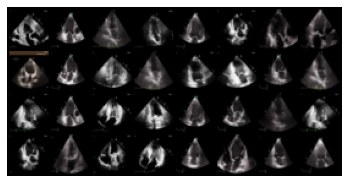

image size:  torch.Size([3, 32, 32])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0972
Epoch 0 Step 119 ave_loss 1.0871
Epoch 0 Step 179 ave_loss 1.0778
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.00      0.00      0.00       409
          3C       0.23      1.00      0.37       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.23      1607
   macro avg       0.08      0.33      0.12      1607
weighted avg       0.05      0.23      0.08      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 1.0863
Epoch 1 Step 119 ave_loss 0.7651
Epoch 1 Step 179 ave_loss 0.5025
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.65      0.84      0.73       409
          3C       0.83      0.89      0.86       367
          4C       0.99      0.82      0.90       831

    accuracy                           0.84      1607
   macro avg       0.82      0.85      0.83      1607
weighted avg       0.87      0.84      0.85      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.2757
Epoch 2 Step 119 ave_loss 0.1949
Epoch 2 Step 179 ave_loss 0.0968
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.60      0.89      0.72       409
          3C       0.72      0.94      0.81       367
          4C       1.00      0.63      0.77       831

    accuracy                           0.76      1607
   macro avg       0.77      0.82      0.77      1607
weighted avg       0.83      0.76      0.77      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.1213
Epoch 3 Step 119 ave_loss 0.0462
Epoch 3 Step 179 ave_loss 0.0475
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.49      0.90      0.64       409
          3C       0.88      0.89      0.89       367
          4C       1.00      0.59      0.74       831

    accuracy                           0.74      1607
   macro avg       0.79      0.79      0.75      1607
weighted avg       0.84      0.74      0.75      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0169
Epoch 4 Step 119 ave_loss 0.0625
Epoch 4 Step 179 ave_loss 0.0133
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.80      0.81       409
          3C       0.72      1.00      0.84       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.87      1607
   macro avg       0.85      0.88      0.85      1607
weighted avg       0.89      0.87      0.87      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0011
Epoch 5 Step 119 ave_loss 0.0002
Epoch 5 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.91      0.77       409
          3C       0.80      0.97      0.88       367
          4C       1.00      0.73      0.85       831

    accuracy                           0.83      1607
   macro avg       0.83      0.87      0.83      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0000
Epoch 6 Step 119 ave_loss 0.0001
Epoch 6 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.91      0.78       409
          3C       0.80      0.97      0.88       367
          4C       1.00      0.73      0.85       831

    accuracy                           0.83      1607
   macro avg       0.83      0.87      0.83      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0000
Epoch 7 Step 119 ave_loss 0.0001
Epoch 7 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.91      0.79       409
          3C       0.80      0.97      0.88       367
          4C       1.00      0.75      0.85       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0001
Epoch 8 Step 119 ave_loss 0.0001
Epoch 8 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.69      0.91      0.79       409
          3C       0.80      0.97      0.88       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.84      0.84      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0001
Epoch 9 Step 119 ave_loss 0.0001
Epoch 9 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.91      0.79       409
          3C       0.80      0.97      0.88       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0001
Epoch 10 Step 119 ave_loss 0.0001
Epoch 10 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.91      0.79       409
          3C       0.79      0.97      0.87       367
          4C       1.00      0.76      0.86       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0001
Epoch 11 Step 119 ave_loss 0.0001
Epoch 11 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.90      0.79       409
          3C       0.79      0.97      0.87       367
          4C       1.00      0.76      0.86       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0001
Epoch 12 Step 119 ave_loss 0.0001
Epoch 12 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.90      0.79       409
          3C       0.79      0.96      0.87       367
          4C       1.00      0.76      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0001
Epoch 13 Step 119 ave_loss 0.0001
Epoch 13 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.90      0.79       409
          3C       0.78      0.96      0.86       367
          4C       1.00      0.76      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0001
Epoch 14 Step 119 ave_loss 0.0001
Epoch 14 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.90      0.79       409
          3C       0.78      0.96      0.86       367
          4C       1.00      0.77      0.87       831

    accuracy                           0.85      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.85      0.85      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0001
Epoch 15 Step 119 ave_loss 0.0001
Epoch 15 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.90      0.79       409
          3C       0.78      0.96      0.86       367
          4C       1.00      0.77      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0001
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.90      0.79       409
          3C       0.78      0.96      0.86       367
          4C       1.00      0.76      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.87      0.84      0.85      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0001
Epoch 17 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.89      0.79       409
          3C       0.78      0.96      0.86       367
          4C       1.00      0.76      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0001
Epoch 18 Step 119 ave_loss 0.0001
Epoch 18 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.90      0.79       409
          3C       0.78      0.95      0.86       367
          4C       1.00      0.77      0.87       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0001
Epoch 19 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.90      0.80       409
          3C       0.78      0.95      0.86       367
          4C       1.00      0.77      0.87       831

    accuracy                           0.85      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.85      0.85      1607

model: vgg16 , size: 32 , augmentation: None
accr:  [22, 83, 76, 73, 86, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
loss:  [1.1304, 0.2271, 0.0061, 0.0022, 0.0056, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.0002, 0.0002, 0.0001]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['2C', '2C', '2C', '2C', '2C', '2C', '4C', '2C']
['4C', '3C', '3C', '3C', '3C', '3C', '3C', '2C']
['3C', '2C', '2C', '2C', '2C', '2C', '2C', '3C']
['3C', '4C', '3C', '3C', '3C', '2C', '4C', '3C']


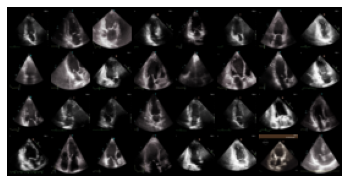

image size:  torch.Size([3, 32, 32])
device: cuda
model: resnet18
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 0.6413
Epoch 0 Step 119 ave_loss 0.2199
Epoch 0 Step 179 ave_loss 0.1022
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.68      0.73       409
          3C       0.71      0.87      0.79       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.87      1607
   macro avg       0.83      0.84      0.83      1607
weighted avg       0.88      0.87      0.87      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.0208
Epoch 1 Step 119 ave_loss 0.0052
Epoch 1 Step 179 ave_loss 0.0298
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.86      0.78       409
          3C       0.81      0.89      0.85       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.87      1607
   macro avg       0.84      0.87      0.85      1607
weighted avg       0.89      0.87      0.87      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.0183
Epoch 2 Step 119 ave_loss 0.0347
Epoch 2 Step 179 ave_loss 0.0306
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.61      0.77      0.68       409
          3C       0.77      0.88      0.82       367
          4C       1.00      0.81      0.89       831

    accuracy                           0.81      1607
   macro avg       0.79      0.82      0.80      1607
weighted avg       0.85      0.81      0.82      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.0048
Epoch 3 Step 119 ave_loss 0.0016
Epoch 3 Step 179 ave_loss 0.0011
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.84      0.80       409
          3C       0.83      0.87      0.85       367
          4C       1.00      0.93      0.96       831

    accuracy                           0.89      1607
   macro avg       0.86      0.88      0.87      1607
weighted avg       0.90      0.89      0.89      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0003
Epoch 4 Step 119 ave_loss 0.0045
Epoch 4 Step 179 ave_loss 0.0042
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.86      0.80       409
          3C       0.85      0.90      0.87       367
          4C       1.00      0.90      0.95       831

    accuracy                           0.89      1607
   macro avg       0.86      0.88      0.87      1607
weighted avg       0.90      0.89      0.89      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0002
Epoch 5 Step 119 ave_loss 0.0004
Epoch 5 Step 179 ave_loss 0.0008
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.89      0.84       409
          3C       0.88      0.90      0.89       367
          4C       1.00      0.93      0.96       831

    accuracy                           0.91      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0154
Epoch 6 Step 119 ave_loss 0.0012
Epoch 6 Step 179 ave_loss 0.0023
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.82      0.76       409
          3C       0.81      0.87      0.84       367
          4C       1.00      0.90      0.94       831

    accuracy                           0.87      1607
   macro avg       0.84      0.86      0.85      1607
weighted avg       0.88      0.87      0.88      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0008
Epoch 7 Step 119 ave_loss 0.0105
Epoch 7 Step 179 ave_loss 0.0013
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.76      0.81       409
          3C       0.77      0.89      0.82       367
          4C       1.00      0.99      0.99       831

    accuracy                           0.91      1607
   macro avg       0.88      0.88      0.87      1607
weighted avg       0.91      0.91      0.91      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0002
Epoch 8 Step 119 ave_loss 0.0001
Epoch 8 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.85      0.76      0.81       409
          3C       0.77      0.88      0.82       367
          4C       1.00      0.99      0.99       831

    accuracy                           0.91      1607
   macro avg       0.87      0.88      0.87      1607
weighted avg       0.91      0.91      0.91      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0082
Epoch 9 Step 119 ave_loss 0.0006
Epoch 9 Step 179 ave_loss 0.0003
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.89      0.86       409
          3C       0.87      0.89      0.88       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.92      1607
   macro avg       0.90      0.91      0.91      1607
weighted avg       0.93      0.92      0.93      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0011
Epoch 10 Step 119 ave_loss 0.0011
Epoch 10 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.90      0.88       409
          3C       0.89      0.88      0.89       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.94      1607
   macro avg       0.92      0.92      0.92      1607
weighted avg       0.94      0.94      0.94      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0004
Epoch 11 Step 119 ave_loss 0.0004
Epoch 11 Step 179 ave_loss 0.0004
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.90      0.87       409
          3C       0.89      0.89      0.89       367
          4C       1.00      0.97      0.98       831

    accuracy                           0.93      1607
   macro avg       0.91      0.92      0.91      1607
weighted avg       0.93      0.93      0.93      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0002
Epoch 12 Step 119 ave_loss 0.0001
Epoch 12 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.89      0.88       409
          3C       0.88      0.89      0.89       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.94      1607
   macro avg       0.91      0.92      0.92      1607
weighted avg       0.94      0.94      0.94      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0001
Epoch 13 Step 119 ave_loss 0.0002
Epoch 13 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.90      0.87       409
          3C       0.89      0.87      0.88       367
          4C       1.00      0.97      0.98       831

    accuracy                           0.93      1607
   macro avg       0.91      0.92      0.91      1607
weighted avg       0.93      0.93      0.93      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0001
Epoch 14 Step 119 ave_loss 0.0001
Epoch 14 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.89      0.87       409
          3C       0.88      0.88      0.88       367
          4C       1.00      0.97      0.98       831

    accuracy                           0.93      1607
   macro avg       0.91      0.91      0.91      1607
weighted avg       0.93      0.93      0.93      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0000
Epoch 15 Step 119 ave_loss 0.0001
Epoch 15 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.89      0.85       409
          3C       0.88      0.87      0.88       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.92      1607
   macro avg       0.90      0.91      0.90      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0001
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.88      0.87       409
          3C       0.87      0.89      0.88       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.94      1607
   macro avg       0.91      0.92      0.91      1607
weighted avg       0.94      0.94      0.94      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0001
Epoch 17 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.89      0.87       409
          3C       0.88      0.88      0.88       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.93      1607
   macro avg       0.91      0.92      0.91      1607
weighted avg       0.93      0.93      0.93      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0001
Epoch 18 Step 119 ave_loss 0.0000
Epoch 18 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.86      0.89      0.87       409
          3C       0.87      0.88      0.88       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.93      1607
   macro avg       0.91      0.92      0.91      1607
weighted avg       0.94      0.93      0.93      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0001
Epoch 19 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.88      0.86       409
          3C       0.87      0.88      0.88       367
          4C       1.00      0.97      0.99       831

    accuracy                           0.93      1607
   macro avg       0.90      0.91      0.91      1607
weighted avg       0.93      0.93      0.93      1607

model: resnet18 , size: 32 , augmentation: None
accr:  [86, 86, 81, 89, 88, 91, 87, 90, 90, 92, 93, 92, 93, 93, 92, 92, 93, 93, 93, 92]
loss:  [0.0959, 0.0005, 0.0017, 0.0, 0.0001, 0.0004, 0.003, 0.0005, 0.1067, 0.0003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004, 0.0018, 0.0, 0.0, 0.0]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['4C', '2C', '3C', '4C', '3C', '3C', '3C', '2C']
['4C', '3C', '4C', '2C', '3C', '2C', '4C', '4C']
['3C', '3C', '2C', '3C', '2C', '2C', '2C', '4C']
['4C', '3C', '2C', '2C', '3C', '4C', '3C', '4C']


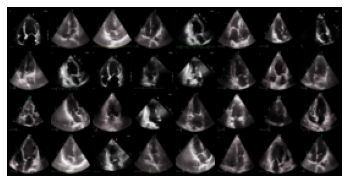

image size:  torch.Size([3, 32, 32])
device: cuda
model: resnet50
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 3.8365
Epoch 0 Step 119 ave_loss 2.7379
Epoch 0 Step 179 ave_loss 2.7190
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.51      0.72      0.60       409
          3C       0.82      0.25      0.38       367
          4C       0.79      0.87      0.82       831

    accuracy                           0.69      1607
   macro avg       0.70      0.61      0.60      1607
weighted avg       0.72      0.69      0.67      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 2.3528
Epoch 1 Step 119 ave_loss 3.0462
Epoch 1 Step 179 ave_loss 1.4704
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.47      0.48      0.47       409
          3C       0.44      0.32      0.37       367
          4C       0.82      0.91      0.87       831

    accuracy                           0.67      1607
   macro avg       0.58      0.57      0.57      1607
weighted avg       0.65      0.67      0.65      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.4814
Epoch 2 Step 119 ave_loss 0.2153
Epoch 2 Step 179 ave_loss 0.2485
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.81      0.77       409
          3C       0.66      0.83      0.73       367
          4C       0.95      0.79      0.86       831

    accuracy                           0.80      1607
   macro avg       0.78      0.81      0.79      1607
weighted avg       0.83      0.80      0.81      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.1217
Epoch 3 Step 119 ave_loss 0.0780
Epoch 3 Step 179 ave_loss 0.0985
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.67      0.62       409
          3C       0.61      0.92      0.74       367
          4C       0.99      0.70      0.82       831

    accuracy                           0.74      1607
   macro avg       0.73      0.76      0.73      1607
weighted avg       0.80      0.74      0.75      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0600
Epoch 4 Step 119 ave_loss 0.0717
Epoch 4 Step 179 ave_loss 0.0566
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.80      0.75       409
          3C       0.67      0.79      0.72       367
          4C       0.96      0.81      0.88       831

    accuracy                           0.81      1607
   macro avg       0.78      0.80      0.78      1607
weighted avg       0.83      0.81      0.81      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0546
Epoch 5 Step 119 ave_loss 0.0782
Epoch 5 Step 179 ave_loss 0.0324
Test model
----------

Evaluation completed in 0m 9s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.59      0.64      0.61       409
          3C       0.57      0.85      0.68       367
          4C       0.98      0.72      0.83       831

    accuracy                           0.73      1607
   macro avg       0.71      0.74      0.71      1607
weighted avg       0.78      0.73      0.74      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0265
Epoch 6 Step 119 ave_loss 0.0453
Epoch 6 Step 179 ave_loss 0.0243
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.68      0.56      0.61       409
          3C       0.57      0.91      0.70       367
          4C       0.99      0.81      0.89       831

    accuracy                           0.77      1607
   macro avg       0.74      0.76      0.73      1607
weighted avg       0.81      0.77      0.77      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0464
Epoch 7 Step 119 ave_loss 0.0553
Epoch 7 Step 179 ave_loss 0.0347
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.57      0.73      0.64       409
          3C       0.55      0.86      0.67       367
          4C       0.98      0.59      0.74       831

    accuracy                           0.69      1607
   macro avg       0.70      0.73      0.68      1607
weighted avg       0.77      0.69      0.70      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0274
Epoch 8 Step 119 ave_loss 0.0202
Epoch 8 Step 179 ave_loss 0.0310
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.71      0.78      0.74       409
          3C       0.65      0.87      0.75       367
          4C       0.99      0.79      0.88       831

    accuracy                           0.81      1607
   macro avg       0.78      0.82      0.79      1607
weighted avg       0.84      0.81      0.81      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0034
Epoch 9 Step 119 ave_loss 0.0053
Epoch 9 Step 179 ave_loss 0.0139
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.80      0.81      0.81       409
          3C       0.69      0.84      0.76       367
          4C       0.98      0.87      0.92       831

    accuracy                           0.85      1607
   macro avg       0.82      0.84      0.83      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0051
Epoch 10 Step 119 ave_loss 0.0200
Epoch 10 Step 179 ave_loss 0.0142
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.68      0.80      0.74       409
          3C       0.64      0.88      0.74       367
          4C       1.00      0.74      0.85       831

    accuracy                           0.79      1607
   macro avg       0.77      0.81      0.78      1607
weighted avg       0.83      0.79      0.80      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0075
Epoch 11 Step 119 ave_loss 0.0024
Epoch 11 Step 179 ave_loss 0.0020
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.80      0.71       409
          3C       0.62      0.86      0.72       367
          4C       0.99      0.69      0.81       831

    accuracy                           0.76      1607
   macro avg       0.75      0.78      0.75      1607
weighted avg       0.81      0.76      0.77      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0167
Epoch 12 Step 119 ave_loss 0.0082
Epoch 12 Step 179 ave_loss 0.0014
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.69      0.72       409
          3C       0.63      0.89      0.74       367
          4C       0.99      0.85      0.91       831

    accuracy                           0.82      1607
   macro avg       0.79      0.81      0.79      1607
weighted avg       0.85      0.82      0.83      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0005
Epoch 13 Step 119 ave_loss 0.0015
Epoch 13 Step 179 ave_loss 0.0009
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.72      0.71       409
          3C       0.60      0.88      0.72       367
          4C       0.99      0.78      0.87       831

    accuracy                           0.79      1607
   macro avg       0.77      0.79      0.77      1607
weighted avg       0.83      0.79      0.80      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0103
Epoch 14 Step 119 ave_loss 0.0148
Epoch 14 Step 179 ave_loss 0.0056
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.75      0.79      0.77       409
          3C       0.67      0.90      0.77       367
          4C       0.99      0.82      0.90       831

    accuracy                           0.83      1607
   macro avg       0.80      0.83      0.81      1607
weighted avg       0.86      0.83      0.83      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0040
Epoch 15 Step 119 ave_loss 0.0013
Epoch 15 Step 179 ave_loss 0.0015
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.62      0.91      0.74       409
          3C       0.66      0.59      0.62       367
          4C       0.99      0.81      0.89       831

    accuracy                           0.79      1607
   macro avg       0.76      0.77      0.75      1607
weighted avg       0.82      0.79      0.79      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0115
Epoch 16 Step 119 ave_loss 0.0043
Epoch 16 Step 179 ave_loss 0.0065
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.73      0.78      0.76       409
          3C       0.68      0.85      0.76       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.83      1607
   macro avg       0.80      0.83      0.81      1607
weighted avg       0.86      0.83      0.84      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0010
Epoch 17 Step 119 ave_loss 0.0002
Epoch 17 Step 179 ave_loss 0.0005
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.77      0.74       409
          3C       0.65      0.85      0.74       367
          4C       0.99      0.83      0.90       831

    accuracy                           0.82      1607
   macro avg       0.79      0.81      0.79      1607
weighted avg       0.85      0.82      0.83      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0019
Epoch 18 Step 119 ave_loss 0.0010
Epoch 18 Step 179 ave_loss 0.0006
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.68      0.69       409
          3C       0.60      0.88      0.71       367
          4C       0.99      0.81      0.89       831

    accuracy                           0.79      1607
   macro avg       0.77      0.79      0.76      1607
weighted avg       0.83      0.79      0.80      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0002
Epoch 19 Step 119 ave_loss 0.0073
Epoch 19 Step 179 ave_loss 0.0023
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.77      0.76       409
          3C       0.65      0.86      0.74       367
          4C       0.98      0.83      0.90       831

    accuracy                           0.82      1607
   macro avg       0.80      0.82      0.80      1607
weighted avg       0.85      0.82      0.83      1607

model: resnet50 , size: 32 , augmentation: None
accr:  [68, 66, 80, 74, 80, 72, 76, 68, 80, 85, 78, 75, 81, 78, 82, 78, 83, 81, 79, 82]
loss:  [0.9555, 0.7249, 0.0541, 0.0308, 0.0161, 0.0361, 0.0361, 0.0021, 0.0001, 0.0439, 0.0037, 0.0001, 0.0004, 0.0, 0.0014, 0.0, 0.0004, 0.0, 0.0, 0.0]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['4C', '3C', '3C', '3C', '3C', '4C', '4C', '3C']
['2C', '3C', '2C', '2C', '4C', '2C', '3C', '3C']
['2C', '4C', '4C', '3C', '2C', '4C', '4C', '2C']
['2C', '4C', '4C', '3C', '4C', '3C', '2C', '2C']


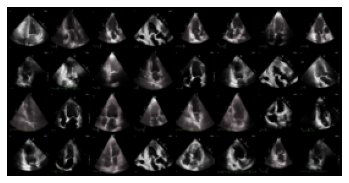

image size:  torch.Size([3, 32, 32])
device: cuda
model: densenet121
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 0.5927
Epoch 0 Step 119 ave_loss 0.2068
Epoch 0 Step 179 ave_loss 0.1227
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.86      0.77       409
          3C       0.80      0.99      0.88       367
          4C       0.99      0.78      0.88       831

    accuracy                           0.85      1607
   macro avg       0.83      0.88      0.84      1607
weighted avg       0.88      0.85      0.85      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.0683
Epoch 1 Step 119 ave_loss 0.0199
Epoch 1 Step 179 ave_loss 0.0290
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.85      0.89      0.87       409
          3C       0.68      0.91      0.78       367
          4C       0.99      0.82      0.90       831

    accuracy                           0.86      1607
   macro avg       0.84      0.87      0.85      1607
weighted avg       0.88      0.86      0.86      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.0066
Epoch 2 Step 119 ave_loss 0.0028
Epoch 2 Step 179 ave_loss 0.0053
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.80      0.82       409
          3C       0.80      0.93      0.86       367
          4C       0.99      0.95      0.97       831

    accuracy                           0.91      1607
   macro avg       0.88      0.89      0.89      1607
weighted avg       0.91      0.91      0.91      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.0014
Epoch 3 Step 119 ave_loss 0.0044
Epoch 3 Step 179 ave_loss 0.0203
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.85      0.97      0.91       409
          3C       0.81      0.92      0.87       367
          4C       0.99      0.87      0.93       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0146
Epoch 4 Step 119 ave_loss 0.0202
Epoch 4 Step 179 ave_loss 0.0068
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.72      0.90      0.80       409
          3C       0.75      0.87      0.81       367
          4C       1.00      0.81      0.89       831

    accuracy                           0.85      1607
   macro avg       0.83      0.86      0.84      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0044
Epoch 5 Step 119 ave_loss 0.0029
Epoch 5 Step 179 ave_loss 0.0079
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.95      0.89       409
          3C       0.81      0.92      0.86       367
          4C       0.98      0.86      0.92       831

    accuracy                           0.90      1607
   macro avg       0.88      0.91      0.89      1607
weighted avg       0.91      0.90      0.90      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0007
Epoch 6 Step 119 ave_loss 0.0005
Epoch 6 Step 179 ave_loss 0.0003
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.95      0.88       409
          3C       0.81      0.91      0.85       367
          4C       1.00      0.86      0.92       831

    accuracy                           0.90      1607
   macro avg       0.87      0.91      0.89      1607
weighted avg       0.91      0.90      0.90      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0003
Epoch 7 Step 119 ave_loss 0.0003
Epoch 7 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.96      0.89       409
          3C       0.84      0.91      0.87       367
          4C       1.00      0.88      0.93       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0003
Epoch 8 Step 119 ave_loss 0.0002
Epoch 8 Step 179 ave_loss 0.0010
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.97      0.87       409
          3C       0.81      0.91      0.86       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.89      1607
   macro avg       0.87      0.90      0.88      1607
weighted avg       0.90      0.89      0.89      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0004
Epoch 9 Step 119 ave_loss 0.0002
Epoch 9 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.90      0.86       409
          3C       0.86      0.92      0.89       367
          4C       0.98      0.91      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.91      0.91      0.91      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0002
Epoch 10 Step 119 ave_loss 0.0002
Epoch 10 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.92      0.87       409
          3C       0.80      0.92      0.86       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.87      0.91      0.89      1607
weighted avg       0.91      0.90      0.90      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0002
Epoch 11 Step 119 ave_loss 0.0001
Epoch 11 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.94      0.88       409
          3C       0.85      0.93      0.88       367
          4C       1.00      0.90      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.92      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0001
Epoch 12 Step 119 ave_loss 0.0002
Epoch 12 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.92      0.88       409
          3C       0.85      0.93      0.89       367
          4C       1.00      0.91      0.95       831

    accuracy                           0.92      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.92      0.92      0.92      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0001
Epoch 13 Step 119 ave_loss 0.0011
Epoch 13 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.97      0.87       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.86      0.92       831

    accuracy                           0.90      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0001
Epoch 14 Step 119 ave_loss 0.0002
Epoch 14 Step 179 ave_loss 0.0004
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.91      0.87       409
          3C       0.90      0.94      0.92       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.93      1607
   macro avg       0.91      0.93      0.92      1607
weighted avg       0.94      0.93      0.93      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0005
Epoch 15 Step 119 ave_loss 0.0002
Epoch 15 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.93      0.87       409
          3C       0.87      0.92      0.89       367
          4C       1.00      0.91      0.95       831

    accuracy                           0.92      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.92      0.92      0.92      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0001
Epoch 16 Step 119 ave_loss 0.0003
Epoch 16 Step 179 ave_loss 0.0004
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.80      0.92      0.86       409
          3C       0.81      0.89      0.85       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.89      1607
   macro avg       0.87      0.90      0.88      1607
weighted avg       0.91      0.89      0.90      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0002
Epoch 17 Step 119 ave_loss 0.0002
Epoch 17 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.94      0.88       409
          3C       0.83      0.90      0.86       367
          4C       1.00      0.90      0.95       831

    accuracy                           0.91      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0002
Epoch 18 Step 119 ave_loss 0.0002
Epoch 18 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.95      0.88       409
          3C       0.88      0.90      0.89       367
          4C       1.00      0.90      0.95       831

    accuracy                           0.91      1607
   macro avg       0.90      0.92      0.90      1607
weighted avg       0.92      0.91      0.92      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0003
Epoch 19 Step 179 ave_loss 0.0011
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.74      0.90      0.81       409
          3C       0.73      0.87      0.79       367
          4C       1.00      0.81      0.89       831

    accuracy                           0.85      1607
   macro avg       0.82      0.86      0.83      1607
weighted avg       0.87      0.85      0.85      1607

model: densenet121 , size: 32 , augmentation: None
accr:  [84, 85, 90, 90, 84, 89, 89, 90, 88, 90, 89, 91, 91, 90, 93, 91, 89, 90, 91, 84]
loss:  [0.1583, 0.0054, 0.0001, 0.0049, 0.0022, 0.0001, 0.0, 0.0002, 0.0002, 0.0001, 0.0036, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.0001]


In [9]:
modelset = ['vgg16', 'resnet18', 'resnet50', 'densenet121']

for i in modelset:
  model = run(modelName=i, imgSize=32, aug="None")

# Demo mô hình với video

In [27]:
def run_video(modelName = 'vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  videotest = namedtuple('videotest', ['id', "ytrues", 'ypreds'])
  id_video = []

  for i, image in enumerate(sample_data.imgs):
    id_video.append(image[0].split("/")[-1].split("_")[0])
  
  video_list = []
  for image in id_video:
    if (image in video_list) == False:
      video_list.append(image)
    else:
      pass

  ytrue = []
  ypred = []

  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  for image, label in sample_data:
    image = image.unsqueeze(0).to('cuda')
    output = modelload(image)
    _, predicted = torch.max(output, dim=1)
    ytrue.append(label)
    ypred += list(predicted.cpu().numpy())

  outputs_video = []
  ytrue_video = []
  ypred_video = []
  index = 0
  for id in video_list:
    index += 1
    vtrue = []
    vpred = []
    for i, img in enumerate(id_video):
      if img == id:
        vtrue.append(ytrue[i])
        vpred.append(ypred[i])

    rate_true = [0, 0, 0]
    rate_pred = [0, 0, 0]
    for label in range(3):
      rate_true[label] = list(vtrue).count(label)
      rate_pred[label] = list(vpred).count(label)

    labeltrue = np.argmax(rate_true)
    labelpred = np.argmax(rate_pred)

    if index %4 != 0:
      print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred, end="  |  ")
    else: print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred)
    ytrue_video.append(labeltrue)
    ypred_video.append(labelpred)
    outputs_video.append(videotest(id=id,ytrues=labeltrue,ypreds=labelpred))
  print(classification_report(ytrue_video, ypred_video, target_names=classes))
  return outputs_video

In [28]:
# result = run_video('vgg16')
for i in modelset:
  result = run_video(modelName=i)

vgg16
id:  158 , true: 0 , pred:  0  |  id:  165 , true: 0 , pred:  0  |  id:  168 , true: 0 , pred:  0  |  id:  169 , true: 0 , pred:  1
id:  171 , true: 0 , pred:  0  |  id:  176 , true: 0 , pred:  0  |  id:  177 , true: 0 , pred:  0  |  id:  178 , true: 0 , pred:  0
id:  181 , true: 0 , pred:  0  |  id:  183 , true: 0 , pred:  0  |  id:  191 , true: 0 , pred:  0  |  id:  192 , true: 0 , pred:  0
id:  157 , true: 1 , pred:  1  |  id:  159 , true: 1 , pred:  1  |  id:  161 , true: 1 , pred:  1  |  id:  162 , true: 1 , pred:  1
id:  166 , true: 1 , pred:  1  |  id:  174 , true: 1 , pred:  1  |  id:  175 , true: 1 , pred:  1  |  id:  179 , true: 1 , pred:  0
id:  185 , true: 1 , pred:  1  |  id:  186 , true: 1 , pred:  1  |  id:  189 , true: 1 , pred:  1  |  id:  190 , true: 1 , pred:  1
id:  194 , true: 1 , pred:  1  |  id:  160 , true: 2 , pred:  1  |  id:  163 , true: 2 , pred:  0  |  id:  164 , true: 2 , pred:  2
id:  167 , true: 2 , pred:  2  |  id:  170 , true: 2 , pred:  2  |  id

In [ ]:
# for i in range(len(result)):
#   if (i+1)%3!=0:
#     print(result[i], end="  |  ")
#   else: print(result[i])

In [31]:
import pandas as pd
def demo_frame(modelName='vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  filename = []
  for i, image in enumerate(sample_data.imgs):
    filename.append(image[0].split("/")[-1])
    # print(image[0].split("/")[-1])
  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  ypred = []
  for image, label in sample_data:
      image = image.unsqueeze(0).to('cuda')
      output = modelload(image)
      _, predicted = torch.max(output, dim=1)
      ypred += list(predicted.cpu().numpy())
  classes0 = {'2C':0 , '3C':1, '4C':2}
  classes0 = dict((v,k) for k,v in classes0.items())
  predictions = [classes0[k] for k in ypred]
  result0 = pd.DataFrame({"Filename":filename, "Prediction":predictions})
  results_file = "./" + modelName + "_results.csv"
  result0.to_csv(results_file,index=False)

In [32]:
for i in modelset:
  result = demo_frame(modelName=i)

vgg16
resnet18
resnet50
densenet121
